## Tugas Tutorial 2
## Nasya Putri Raudhah Dahlan
## 23/513931/PA/21967

### Import Libaries

In [ ]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

### Load Dataset

In [ ]:
!pip install -q gdown
!gdown 1QJSXNohD32xZ-uZKt5V9_wJNtL0-GVeU
!unzip -q CV_Tutorial.zip

Downloading...
From: https://drive.google.com/uc?id=1QJSXNohD32xZ-uZKt5V9_wJNtL0-GVeU
To: /content/CV_Tutorial.zip
100% 8.31M/8.31M [00:00<00:00, 275MB/s]


### Load Groun Truth

In [ ]:
gt = []
with open("/content/CV_Tutorial/gt.txt", 'r') as f:
  for line in f:
    values = line.strip().split(',')
    values = [int(float(v)) for v in values]
    gt.append(values)

In [ ]:
!cat "/content/CV_Tutorial/gt.txt"

# melihat bounding boxes

131.21,50.013,167.71,139.66
131.21,50.642,167.71,139.66
131.52,51.271,167.71,139.66
131.52,51.586,167.71,139.97
131.52,51.586,167.71,140.29
131.52,52.844,167.71,140.6
131.52,53.473,167.71,141.86
130.58,54.731,167.39,142.18
130.27,55.99,166.45,143.75
129.32,57.248,166.14,145.01
129.32,58.82,165.82,146.89
129.32,61.337,165.82,148.78
129.32,63.539,165.82,151.3
130.58,66.684,166.77,154.13
131.84,70.144,168.02,157.27
134.36,74.548,170.86,161.68
136.87,79.266,173.37,167.34
140.33,84.299,177.46,171.43
146.31,88.073,182.5,175.2
151.66,92.792,188.48,179.29
158.58,96.566,195.08,183.38
166.14,100.03,202.64,186.84
173.37,102.54,210.5,189.99
180.3,104.43,218.05,191.56
187.85,106,225.92,193.13
196.03,107.26,235.04,194.08
203.58,107.89,243.23,194.71
210.5,107.89,250.15,195.96
216.48,109.46,256.13,196.59
221.2,109.46,261.16,196.59
224.66,109.15,264.62,196.59
226.23,109.46,266.51,196.59
226.23,107.89,266.82,195.65
222.77,107.89,263.36,195.33
217.74,107.26,257.38,194.71
211.13,106.63,250.46,194.71
204.2

### Load Video Dataset

In [ ]:
video_path = '/content/CV_Tutorial/video (1).mp4'
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
  raise RuntimeError("Failed to open video file")

In [ ]:
ret, prev_frame = cap.read()
if not ret:
  raise RuntimeError("Failed to read first frame")

### Shi Tomasi Corner Detection Parameters

In [ ]:
#Shi-Tomasi Corner Detection Parameters

ST_PARAMS = dict(
  maxCorners=10,
  qualityLevel=0.3,   # lebih rendah
  minDistance=7,       # supaya titik-titik lebih rapat
  blockSize=7
)

○ maxCorners → Limits the number of detected corners (only the strongest 10 are
kept).

○ qualityLevel → Filters out weak corners (higher = stricter).

○ minDistance → Ensures corners are spatially distinct.

○ blockSize → Defines the window size for computing corner gradients.

### Lucas Kanade Optical Flow Parameters

In [ ]:
LK_PARAMS = dict(
  winSize=(20, 20),
  maxLevel=2,
  criteria=(cv2.TERM_CRITERIA_EPS|cv2.TERM_CRITERIA_COUNT,10,0.03)
)

- winSize → Larger windows are robust to fast motion but slower to compute.
- maxLevel → Enables hierarchical tracking for scalability.
- criteria → Stops iteration when either the error (EPS) falls below 0.03, or the max
iterations (COUNT) reach 10.

### Initialize ROI from Ground Truth

In [ ]:
x, y, w, h = map(int, gt[0][:4])

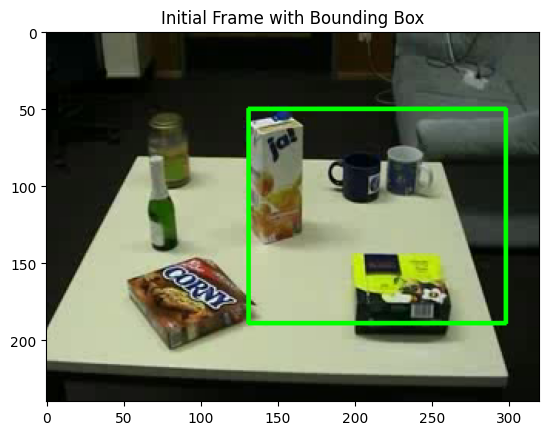

In [ ]:
frame_with_bbox = prev_frame.copy()
cv2.rectangle(frame_with_bbox, (x, y), (x+w, y+h), (0, 255, 0), 2)
# Display the annotated frame
plt.imshow(cv2.cvtColor(frame_with_bbox, cv2.COLOR_BGR2RGB))
plt.title("Initial Frame with Bounding Box")
plt.show()

### Prepare ROI and Feature Points

To track the object, we:
- Extract the ROI (cropped region within the bounding box).
- Convert it to grayscale (required for feature detection).

In [ ]:
# Crop the ROI and convert to grayscale
roi = prev_frame[y:y+h, x:x+w]
roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Detect features in the entire frame
all_points = cv2.goodFeaturesToTrack(prev_gray, mask=None, **ST_PARAMS)

Detect keypoints in the entire frame, then filter those within the ROI.

In [ ]:
# Filter features inside the initial bounding box
selected_points = []
for point in all_points:
  px, py = point.ravel()
  if x <= px <= x+w and y <= py <= y+h:
    selected_points.append(point)
if not selected_points:
  raise RuntimeError("No features found in the initial bounding box!")

prevPts = np.array(selected_points, dtype=np.float32) # Format for tracking

In [ ]:
selected_points

[array([[133.,  61.]], dtype=float32),
 array([[209., 147.]], dtype=float32),
 array([[246., 170.]], dtype=float32),
 array([[189.,  90.]], dtype=float32)]

selected points yang memenuhi kriteria di atas ternyata terdapat 4 points

### Initialize Video Writer for Output

To save the tracking results as a video, we configure a VideoWriter object with the same
resolution and frame rate (FPS) as the input video.

In [ ]:
# Get video properties from the input
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define output file and codec (MP4 format)
output_path = 'vid.mp4' #ini videonya, bisa di rename juga
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for MP4 format

# Initialize VideoWriter
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

### Initialize Visualization Mask

A mask is used to visualize the optical flow trails (e.g., motion paths) during tracking. We
also initialize a frame_count to monitor progress.

In [ ]:
# Create a black mask (same size as input frames)
mask = np.zeros_like(prev_frame)

# Track frame count for debugging/analysis
frame_count = 0

### Object Tracking Loop with Optical Flow

In [ ]:
## Initial Setup
import time
start_time = time.time() # Track processing start time

## Frame Processing Loop
while True:
  # Read next frame
  ret, frame = cap.read()
  if not ret: # Exit loop if video ends
    break

  # Convert frame to grayscale (required for optical flow)
  frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  if prevPts is not None:
    # Calculate optical flow between previous and current frame
    nextPts, status, _ = cv2.calcOpticalFlowPyrLK( # status true: corner masih ada, false: corner hilang
      prev_gray, frame_gray, prevPts, None, **LK_PARAMS
    )

## Tracking Visualization
    if nextPts is not None:
      # Filter only successfully tracked points
      good_new = nextPts[status == 1]
      good_prev = prevPts[status == 1]

      # Draw tracking markers (visualisasi dengan menggambar lingkaran/titik)
      for (new, prev) in zip(good_new, good_prev):
        x_new, y_new = new.ravel()
        x_prev, y_prev = prev.ravel()

        # Convert to integers for drawing functions
        x_new, y_new = map(int, (x_new, y_new))
        x_prev, y_prev = map(int, (x_prev, y_prev))

        # Draw current position (green dot)
        frame = cv2.circle(frame, (x_new, y_new), 5, (0, 255, 0), -1)

## Performance Metrics and Output
      # Combine frame with motion trail mask
      visualized_frame = cv2.add(frame, mask)

      # Calculate and display real-time FPS
      elapsed_time = time.time() - start_time
      fps = frame_count / elapsed_time if elapsed_time > 0 else 0
      cv2.putText(
        visualized_frame,
        f"FPS: {fps:.2f}",
        (width - 200, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1, (255, 0, 0), 2, cv2.LINE_AA
      )

      # Write frame to output video
      out.write(visualized_frame)

      # Update points for next iteration
      prevPts = good_new.reshape(-1, 1, 2)

## Tracking Failure Handling
    else: # Tracking Failure Handling
      # If tracking fails, write original frame without annotations
      out.write(frame)
      prevPts = None

  else:
    # No points to track (initial failure case)
    out.write(frame)

## Frame Management
  # Update previous frame reference
  prev_gray = frame_gray.copy()
  frame_count += 1 # Increment frame counter

In [ ]:
# Release video capture and writer objects
cap.release() # Close input video file
out.release() # Finalize output video writing
# Close all OpenCV windows
cv2.destroyAllWindows()
# Print completion message with output path
print(f"Processing complete. Output saved to {output_path}")

Processing complete. Output saved to vid.mp4
